# Job Word Embeddings

here are some goals that I want to accomplish in this notebook
 - clean our granted patent dataset to only have utility work, and have only patent abstract, patent date, and patent id columns (in case we want to use g_cpc_current)
 - clean our kaggle dataset by removing stop words to get relevant words. Then, tokenize, and get word embeddings using gensim
 - clean our g_patent similarily
 - start to use bag of words and tf-idf to get similarities between the job postings and g_patents in nearby years (+/- 2 or 3 years)

## Imports and Reading in Files

In [1]:
# Here, we are going to load the generic g_patent and g_cpc_current DataFrames as well as our pandas, matplotlib etc
import pandas as pd
import gensim
import nltk
from nltk.corpus import stopwords 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set( style = 'white' )

# Here is a variable change in the width of the string for the columns. I am placing it here as it may need
# to be changed often, so I will move it right here!
pd.options.display.max_colwidth = 1000

# this is the english stop words list
eng_stp_wrds = stopwords.words('english')

In [2]:
# here is the granted patent dataset that we will use alongside the job posting abstracts
df_patent = pd.read_csv("../g_patent.tsv", delimiter='\t', dtype={'patent_id': str, 
                                                        'patent_type': str, 
                                                        'patent_title': str,
                                                        'patent_abstract': str,
                                                        'wipo_kind': str,
                                                        'num_claims': int,
                                                        'withdrawn': int,
                                                        'filename': str}, parse_dates=[2])
df_patent.drop(df_patent[df_patent['patent_type'] != 'utility'].index, inplace=True)
df_patent.drop(axis=1, columns=["patent_type", "patent_title", "wipo_kind","num_claims", "withdrawn", "filename"], inplace=True)
df_patent.head(20) 

,patent_id,patent_date,patent_abstract
0,10000000,2018-06-19,"A frequency modulated (coherent) laser detection and ranging system includes a read-out integrated circuit formed with a two-dimensional array of detector elements each including a photosensitive region receiving both return light reflected from a target and light from a local oscillator, and local processing circuitry sampling the output of the photosensitive region four times during each sample period clock cycle to obtain quadrature components. A data bus coupled to one or more outputs of each of the detector elements receives the quadrature components from each of the detector elements for each sample period and serializes the received quadrature components. A processor coupled to the data bus receives the serialized quadrature components and determines an amplitude and a phase for at least one interfering frequency corresponding to interference between the return light and the local oscillator light using the quadrature components."
1,10000001,2018-06-19,"The injection molding machine includes a fixed platen, a moveable platen moving forward and backward by a toggle link, a base plate supporting the toggle link, a driving part for mold clamping to operate the toggle link, a driving part for mold thickness adjustment to adjust a mold thickness, and a control unit to calculate a movement distance gap before a clamping process by controlling the driving part for mold thickness adjustment to move the base plate backward and then move the base plate forward to a target movement position based on a fold amount of the toggle link, and control the driving part for mold thickness adjustment using a value obtained by deducting the movement distance gap from the fold amount of the toggle link when producing a clamp force."
2,10000002,2018-06-19,"The present invention relates to: a method for manufacturing a polymer film, the method including a base film forming step for co-extruding a first resin containing a polyamide-based resin and a second resin containing a copolymer including polyamide-based segments and polyether-based segments; a co-extruded film including a base film including a first resin layer containing a polyamide-based resin, and a second resin layer containing a copolymer having polyamide-based segments and polyether-based segments; to a co-extruded film including a base film including a first resin layer and a second resin layer, which have different melting points; and to a method for manufacturing a polymer film, the method including a base film forming step including a step of co-extruding a first resin and a second resin, which have different melting points."
3,10000003,2018-06-19,"The invention relates to a method for producing a container (2) from a thermoplastic, having at least one surround (4), provided in the container wall (1), for a container opening. The surround (4) comprises a structure behind which parts of the container wall (1) extend and/or which is penetrated by said parts. The method is carried out using a multi-part blow mold that has at least two mold parts, each having at least one cavity, wherein the surround is placed as an insert in the cavity (10) of the blow mold (7). The method comprises pressing the preform that has been forced into the cavity (10) into the structure of the surround (4) by means of a tool which is brought to bear on the preform (12) on the side of the preform facing away from the cavity (10)."
4,10000004,2018-06-19,"The present invention relates to provides a double-oriented film, co-extrude, and of low thickness, with a layered composition that gives the property of being of high barrier to gases and manufactured by the process of co-extrusion of 3 bubbles, which gives the property of when being thermoformed, ensure the distribution of uniform thickness in the walls, base, folds, and corners of the formed tray saving a minimum of 50% of plastic without diminishing its gas barrier and its resistance to punct

In [3]:
df_patent['patent_abstract'].fillna("filled spot for NaN", inplace=True) # there was apparently some NaN spots in the abstract column

In [4]:
df_cpc = pd.read_table("../g_cpc_current.tsv", delimiter="\t", dtype={"patent_id": str,
                                                               "cpc_sequence": int,
                                                               "cpc_section": str,
                                                               "cpc_subclass": str,
                                                               "cpc_group": str,
                                                               "cpc_type": str,
                                                               "cpc_symbol_position": str})
df_cpc.drop(axis=1, columns=df_cpc.columns[3:], inplace=True)
df_cpc.head(20) # this may not be used within this specific notebook, but it is here loaded in case we want to check the type of patents

,patent_id,cpc_sequence,cpc_section
0,5664589,0,A
1,10439720,3,G
2,9840937,2,F
3,7407213,1,B
4,11014297,4,B
5,6959012,0,H
6,6725745,0,H
7,8625669,7,H
8,11011577,16,H
9,5087721,1,A


In [5]:
online_df = pd.read_csv('../onlinejobpostings.csv') # here we have the online job posting dataset that was on kaggle
online_df['date'] = pd.to_datetime(online_df['date'], errors = 'coerce')
online_df.drop(axis=1, inplace=True, columns=online_df.columns[4:])
online_df

,jobpost,date,Title,Company
0,"AMERIA Investment Consulting Company\r\nJOB TITLE: Chief Financial Officer\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.\r\nJOB RESPONSIBILITIES: \r\n- Supervises financial management and administrative staff, including\r\nassigning responsibilities, reviewing employees' work processes and\r\nproducts, counseling employees, giving performance evaluations, and\r\nrecommending disciplinary action;\r\n- Serves as member of management team participating in both strategic\r\nand operational planning for the company;\r\n- Directs and ove...",2004-01-05,Chief Financial Officer,AMERIA Investment Consulting Company
1,"International Research & Exchanges Board (IREX)\r\nTITLE: Full-time Community Connections Intern (paid internship)\r\nDURATION: 3 months\r\nLOCATION: IREX Armenia Main Office; Yerevan, Armenia \r\nDESCRIPTION: IREX currently seeks to fill the position of a paid\r\nIntern for the Community Connections (CC) Program. The position is based\r\nin the Yerevan office however applicants must be willing to travel\r\nthroughout Armenia as necessary. This position reports directly to the\r\nCC Program Manager.\r\nRESPONSIBILITIES: \r\n- Presenting the CC program to interested parties; \r\n- Assisting in planning and scheduling of programmatic meetings and\r\nevents (this includes coordinating logistics for CC staff, visitors and\r\nparticipants);\r\n- Assisting the Program Staff;\r\n- Translation/Interpretation from Armenian to English and vice versa;\r\n- Helping create, maintain and update the CC filing system and\r\ndatabases;\r\n- Completing general administrative tasks for the CC...",2004-01-07,Full-time Community Connections Intern (paid internship),International Research & Exchanges Board (IREX)
2,"Caucasus Environmental NGO Network (CENN)\r\nJOB TITLE: Country Coordinator\r\nPOSITION DURATION: Renewable annual contract\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: Public outreach and strengthening of a growing\r\nnetwork of environmental NGOs, businesses, international organizations\r\nand public agencies. Will serve as primary contact between CENN and\r\npublic. This is a full-time position.\r\nJOB RESPONSIBILITIES: \r\n- Working with the Country Director to provide environmental information\r\nto the general public via regular electronic communications and serving\r\nas the primary local contact to Armenian NGOs and businesses and the\r\nArmenian offices of international organizations and agencies;\r\n- Helping to organize and prepare CENN seminars/ workshops;\r\n- Participating in defining the strategy and policy of CENN in Armenia,\r\nthe Caucasus region and abroad.\r\nREQUIRED QUALIFICATIONS: \r\n- Degree in environmentally related field, or 5 years ...",2004-01-07,Country Coordinator,Caucasus Environmental NGO Network (CENN)
3,"Manoff Group\r\nJOB TITLE: BCC Specialist\r\nPOSITION LOCATION: Manila, Philippines\r\nJOB DESCRIPTION: The LEAD (Local Enhancement and Development for\r\nHealth) BCC Specialist will apply state-of-the-art approaches in working\r\nwith LGUs (Local Government Units) and NGOs to help them to identify and\r\naddress provider-caused barriers to service provision as well as to\r\nidentify and address supports for good service delivery by developing\r\ntools that may be adapted to each LGU's needs. S/he will work with LEAD\r\nstaff across all components to support quality service delivery and will\r\nalso monitor implementation of improved service delivery in LGUs, and\r\nwill provide additional assistance to LG

## Word Embedding Code

In [6]:
# We are going to be using sklearn to do the cosine similarity comparisons using the tfidf method
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()

In [26]:
cos_count = { "-2":  [0] * 12, "-1":  [0] * 12, "0":  [0] * 12, "1":  [0] * 12}
cos_count = pd.DataFrame(cos_count)
cos_count.index = range(2004, 2016, 1)
cos_count # we are making a dataframe to be able to display and plot our results

,-2,-1,0,1
2004,0,0,0,0
2005,0,0,0,0
2006,0,0,0,0
2007,0,0,0,0
2008,0,0,0,0
2009,0,0,0,0
2010,0,0,0,0
2011,0,0,0,0
2012,0,0,0,0
2013,0,0,0,0


In [27]:
for year in range(2004, 2016): # clustering each year
    year_df = remote_jobs[(remote_jobs['date'].dt.year == year)]
    for level in range(-2, 2): # getting patents in range between 2 years back all the way up to one year ahead
        curr_level = df_patent[(df_patent['patent_date'].dt.year == (year + level))] # current cluster of patents, dependent on year and shift
        if len(curr_level) == 0: continue
        for row_index, row in year_df.iterrows():
            curr = year_df.loc[row_index]
            for patent_row in range(curr_level.index[0], curr_level.index[-1], 50):
                doc1 = curr['jobpost']
                doc2 = curr_level['patent_abstract'].loc[patent_row]
                docs = [doc1, doc2]
                tfidf_vector = vectorizer.fit_transform(docs)
                similarities = cosine_similarity(tfidf_vector)
                if similarities[0][1] > 0.75:
                    cos_count.loc[year, str(level)] += 1
        

In [29]:
patent_job_simalarity = pd.read_pickle("cos_count.pkl")
patent_job_simalarity.index.name = "Years"
patent_job_simalarity

,-2,-1,0,1
Years,,,,
2004,4,10,4,1
2005,5,7,1,1
2006,96,87,84,72
2007,58,59,75,73
2008,343,285,288,322
2009,208,205,214,213
2010,880,938,927,1033
2011,570,589,658,707
2012,208,267,295,236


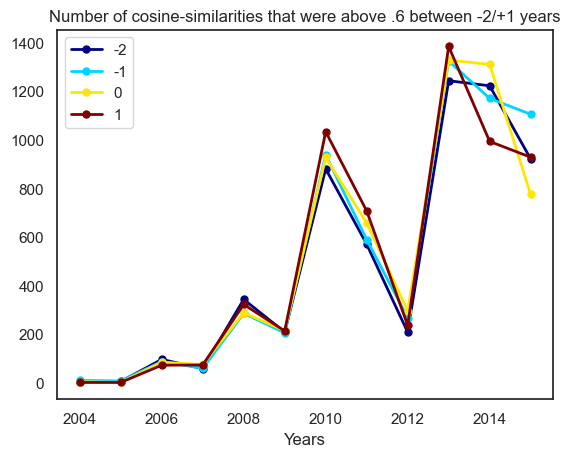

In [32]:
ax = patent_job_simalarity.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Number of cosine-similarities that were above .6 between -2/+1 years')

In [13]:
res = patent_job_simalarity.div(patent_job_simalarity.sum(axis=1), axis=0)
print(res)

             -2        -1         0         1
Years                                        
2004   0.210526  0.526316  0.210526  0.052632
2005   0.357143  0.500000  0.071429  0.071429
2006   0.283186  0.256637  0.247788  0.212389
2007   0.218868  0.222642  0.283019  0.275472
2008   0.277060  0.230210  0.232633  0.260097
2009   0.247619  0.244048  0.254762  0.253571
2010   0.232927  0.248280  0.245368  0.273425
2011   0.225832  0.233360  0.260697  0.280111
2012   0.206759  0.265408  0.293241  0.234592
2013   0.235461  0.250805  0.251563  0.262171
2014   0.260277  0.249201  0.279020  0.211502
2015   0.246983  0.296326  0.207831  0.248860


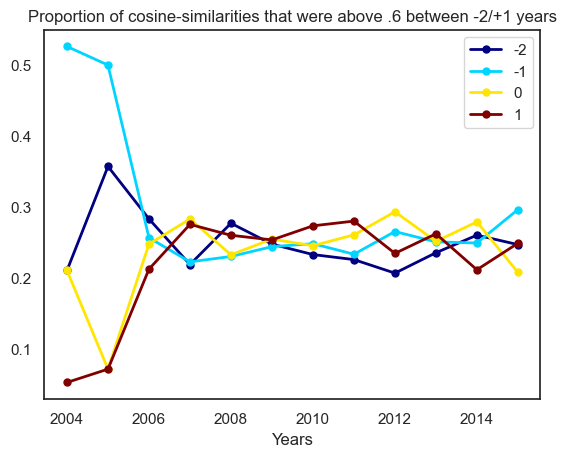

In [31]:
ax = res.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Proportion of cosine-similarities that were above .6 between -2/+1 years')

## Now we will find the number of online job postings that where also programming / developer related

In [7]:
remote_jobs = pd.concat([online_df.loc[online_df['jobpost'].str.contains("remote", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("WFH", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("work from home", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("mobile work", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("virtual", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("online meeting", case=True)],
                        online_df.loc[online_df['jobpost'].str.contains("distributed work", case=True)]], ignore_index=True) # we are getting remote job online posts only
remote_jobs['date'].fillna("", inplace=True)
remote_jobs

,jobpost,date,Title,Company
0,"World Vision Armenia\r\nJOB TITLE: Project Assistant\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: World Vision Armenia announces a full-time position\r\nfor Project Assistant for the implementation of a Mobile Medical Teams\r\nand Primary Health care project. The position is based in World Vision\r\nArmenia' National office, Yerevan with extensive countrywide travel.\r\nCandidates must be flexible team players willing to travel extensively\r\nto field locations. \r\nThe Project Assistant will support the Yerevan based MMT staff with\r\nmiscellaneous administrative and project implementation duties.\r\nJOB RESPONSIBILITIES: \r\n- Provide daily administrative and technical support to the MMT Program\r\ncoordinator and Health Program Manager in implementation of the MMT\r\nProgram Activities in the sites;\r\n- Provide minor procurement, registration of drugs and other medical\r\nsupplies, customs clearance and additional support to field staff as\r\nrequired;\r\n...",2004-02-22,Project Assistant,World Vision Armenia
1,"World Vision Armenia\r\nJOB TITLE: MMT Project Manager\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: World Vision Armenia announces a full-time position\r\nfor MMT Project Manager for the implementation of a Mobile Medical Teams\r\nand Primary Health care project. The position is based in World Vision\r\nArmenia' National office, Yerevan with extensive countrywide travel.\r\nCandidates must be flexible team players willing to travel extensively\r\nto field locations. \r\nMMT project Manager will lead and work with other members of the MMT\r\nteam. This position is responsible for immediate Management and\r\noversight of program implementation, monitoring and evaluation,\r\nreporting.\r\nJOB RESPONSIBILITIES: As a senior member of the MMT and reporting to\r\nthe Health Program Manager, the MMT Project Manager will manage a team\r\nof three people (two health coordinators and an assistant) for the first\r\nyear of program implementation that will gradually expand...",2004-02-22,MMT Project Manager,World Vision Armenia
2,"World Vision Armenia\r\nJOB TITLE: Health Coordinators (two positions are open)\r\nJOB DESCRIPTION: World Vision Armenia announces full-time positions\r\nfor Health Coordinators for the implementation of a Mobile Medical Teams\r\nand Primary Health care project. The positions are based in World Vision\r\nArmenia' National office, Yerevan with extensive countrywide travel.\r\nCandidates must be flexible team players willing to travel extensively\r\nto field locations. \r\nMMT Health Coordinators will be responsible for direct coordination,\r\nsupervision and technical monitoring of the program success and\r\nconstrains in Lori and Gegharkunik. \r\nJOB RESPONSIBILITIES: As part of MMT team, each Health Coordinator\r\nwill work collaboratively with sites they are responsible for and local\r\npartners and will report to the MMT Project Manager. The essential\r\nresponsibilities include:\r\n- Coordinate the obtaining and/or development/ adaptation of MMT related\r\nguides and prot...",2004-02-22,Health Coordinators (two positions are open),World Vision Armenia
3,"World Vision Armenia\r\nTITLE: Health Coordinator\r\nTERM: Full-time\r\nSTART DATE/ TIME: This position starts in May 2004\r\nLOCATION: World Vision Armenia' National office, Yerevan with extensive\r\ncountrywide travel. Candidate must be flexible team player willing to\r\ntravel extensively to field locations\r\nJOB DESCRIPTION: WORLD VISION ARMENIA announces full-time position of\r\nHealth Coordinator for the implementation of a Mobile Medical Teams and\r\nPrimary Health care project.\r\nMMT Health Coordinator will be responsible for direct coordination,\r\nsupervision and technical monitoring of the program success and\r\nconstrains in Lori.\r\nJOB RESPONSIBILITIES:\r\n- Coordinate the obtaining and/or development/adaptation of MMT related\r\nguides and protocols during the start-up pha

In [13]:
developer_keywrds = ["Software Developer", "Data Engineer", "Web Developer", "Database", "Computer hardware",
                     "Computer Systems", "Information Security", "Systems analyst", "Computer Network", "Network",
                     "Systems engineering", "Web Designer", "Systems Administrator", "Software", "User experience", 
                     "Information technology", "technology", "Video game", "Developer"]
developer_jobs = pd.concat([remote_jobs.loc[remote_jobs['jobpost'].str.contains(x, case=True)] for x in developer_keywrds], ignore_index=True)
developer_jobs.drop_duplicates(inplace=True)
print(len(remote_jobs))
print(len(developer_jobs))
developer_jobs

444
238


,jobpost,date,Title,Company
0,"Vested Development, Inc.\r\nTITLE: Senior Software Developer/ Lead Developer\r\nANNOUNCEMENT CODE: Lead Developer C++\r\nTERM: Long-term\r\nLOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: N/A\r\nJOB RESPONSIBILITIES: Working with US representatives (business\r\nrepresentatives, as well as development team members), cooperating with\r\ncustomer representatives, fine-tuning requirements, development of\r\ndesign of system key components, management of remote development team\r\nin Russia.\r\nREQUIRED QUALIFICATIONS:\r\n- Work experience in IT industry of over 5 years; \r\n- Work experience as a lead developer for more than 3 years;\r\n- Experience in the development of large Web systems and enterprise\r\napplications;\r\n- Experience in system and/or business analysis;\r\n- Experience in management of large development teams;\r\n- Experience in the development of large systems with the following\r\ntechnologies: C++, .Net, XML, HTML, Oracle, Linux;\r\n- Ability to develop and su...",2004-09-30,Senior Software Developer/ Lead Developer,"Vested Development, Inc."
1,"Imagenomic LLC\r\nTITLE: Software Developer\r\nTERM: Full time/ Part time, flexible hours\r\nOPEN TO/ ELIGIBILITY CRITERIA: All qualified candidates\r\nSTART DATE/ TIME: Immediately\r\nDURATION: Long term\r\nLOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: Support critical work streams within Companys\r\nSoftware Engineering Team by carrying out the key tasks in a full\r\nsoftware development cycle including design, prototyping, development,\r\ntest and release as well as in maintaining industry standard practices\r\nand processes for continual improvement. The position will provide\r\nauxiliary, GUI and core code development primarily in C++ on a daily,\r\ntime-sensitive basis in response to scheduled and/or ad-hoc tasking.\r\nThis position will also maintain technical documentation and will\r\nrequire performance based reporting. For an initial timeframe, this\r\nposition can work from home with flexible working schedule, while\r\nmeeting high-quality standards for responsiv...",2008-05-23,Software Developer,Imagenomic LLC
2,"SFL LLC\r\nTITLE: PHP Senior Software Developer\r\nTERM: Full time\r\nOPEN TO/ ELIGIBILITY CRITERIA: All qualified candidates\r\nSTART DATE/ TIME: ASAP\r\nDURATION: Permanent\r\nLOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: SFL is looking for a full-time Senior PHP Developer to\r\nwork for complex and long-term projects. The projects will deal with\r\ncustomers from Western Europe and Armenia.\r\nJOB RESPONSIBILITIES:\r\n- Produce and maintain clean, high quality standard compliant website\r\napplications;\r\n- Develop codes that are cross-browser and cross-platform compatible;\r\n- Communicate remotely with offshore team;\r\n- Maintain cutting edge knowledge of current and emerging technologies,\r\nindustry trends and standards.\r\nREQUIRED QUALIFICATIONS:\r\n- Advanced working knowledge in PHP, MySQL, HTML/DHTML, XML, CSS and\r\nJavaScript, AJAX;\r\n- Skills with Linux Operating System: System Administration, Writing\r\nShell scripts etc.;\r\n- Knowledge of Flesh/Flex and...",2009-01-08,PHP Senior Software Developer,SFL LLC
3,"Imagenomic LLC\r\nTITLE: Software Developer\r\nTERM: Full time/ Part time, flexible hours\r\nOPEN TO/ ELIGIBILITY CRITERIA: All qualified candidates\r\nSTART DATE/ TIME: Immediately\r\nDURATION: Long term\r\nLOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: Imagenomic LLC is looking for a Software Developer to\r\nsupport critical work streams within Companys Software Engineering Team\r\nby carrying out the key tasks in a full software development cycle\r\nincluding design, prototyping, development, test and release as well as\r\nin maintaining industry standard practices and processes for continual\r\nimprovement. The position will provide auxiliary, GUI and core code\r\ndevelopment primarily in C++ on a daily, time-sensitive basis in\r\nresponse to scheduled and/ or ad-hoc tasking. This positio

[Text(0.5, 0, 'All Remote Online Job Postings'),
 Text(0, 0.5, 'Number of Job Postings')]

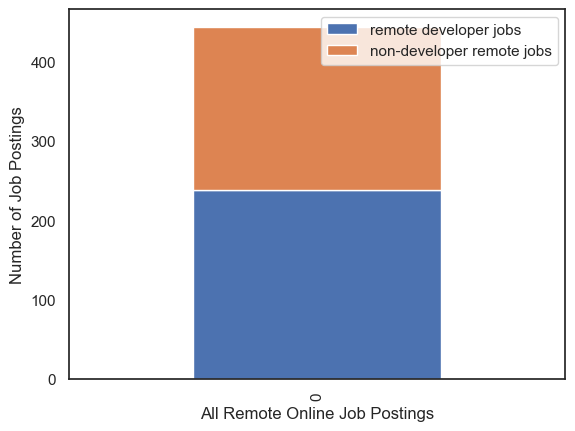

In [32]:
remote_developer_proportion = pd.DataFrame({'remote developer jobs': [len(developer_jobs)], 'non-developer remote jobs': [len(remote_jobs) - len(developer_jobs)]})
ax = remote_developer_proportion.plot.bar(stacked=True)
ax.set(xlabel="All Remote Online Job Postings", ylabel="Number of Job Postings")

## Do programming related jobs correlate to more remote job patents?

In [34]:
dvlpr_jobs = pd.concat([online_df.loc[online_df['jobpost'].str.contains(x, case=True)] for x in developer_keywrds], ignore_index=True)
dvlpr_jobs.drop_duplicates(inplace=True)
dvlpr_jobs

,jobpost,date,Title,Company
0,"Yerevan Brandy Company\r\nJOB TITLE: Software Developer\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB RESPONSIBILITIES: \r\n- Rendering technical assistance to Database Management Systems;\r\n- Realization of SQL servers maintenance activities: back-up and\r\nreplication;\r\n- Participation in designing of software development projects.\r\nREQUIRED QUALIFICATIONS: \r\n- University degree; economical background is a plus;\r\n- Excellent knowledge of Windows 2000 Server, Networking TCP/ IP\r\ntechnologies, MS SQL 2000 Server, Visual Basic 6;\r\n- At least 2 years of experience in database software development;\r\n- Good knowledge of English.\r\nREMUNERATION: Will be commensurate with the norms accepted in the\r\nCompany.\r\nAPPLICATION PROCEDURES: Successful candidates should submit\r\n- CV; \r\n- 2 relevant Recommendation Letters (from previous employers);\r\n- Copy (-ies) of Diploma (-s) and relevant certificates (if available);\r\n- 1 color photo (3x4)\r\neither to: 2 Isakov ...",2004-01-10,Software Developer,Yerevan Brandy Company
1,"NetMen Ltd.\r\nJOB TITLE: Software Developers\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: We are looking for a Programmers with knowledge of\r\nJava, Jsp, J2EE.\r\nREQUIRED QUALIFICATIONS: \r\n- Minimum 3 years experience of software development;\r\n- Strong object oriented skills;\r\n- Strong technical background in Java software development, J2EE, XML,\r\nWeb Services, SOAP;\r\n- Strong OOA&D skills;\r\n- Practical knowledge of UML;\r\n- Experience with international projects; \r\n- Knowledge of English and German languages (not mandatory, but a big\r\nplus).\r\nREMUNERATION: Depends on skills and previous experience.\r\nAPPLICATION PROCEDURES: Send your resume to: mhakobyan@.... Only\r\nshort-listed candidates will be asked to pass an interview. \r\nPlease clearly mention in your application letter that you learned of\r\nthis job opportunity through Career Center and mention the URL of its\r\nwebsite - www.careercenter.am, Thanks.\r\nAPPLICATION DEADLINE: ...",2004-02-17,Software Developers,NetMen Ltd.
2,"Synergy International Systems, Inc./Armenia\r\nJOB TITLE: Software Developer \r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: Synergy International Systems, Inc./Armenia seeks to\r\nfill the long-term position of Software Developer. The responsibilities\r\nof this position are focused on core software development tasks in\r\nSynergy International Systems, Inc. Synergy's main focus is on\r\ndeveloping integrated state-of-the-art Web Database and Web Portal\r\nsystems for business intelligence, knowledge management and e-Government\r\nsolutions. \r\nThis position will be filled by a software developer with a proven\r\nhistory of producing quality software product in a commercial setting.\r\nExperience in a dynamic workplace with solid software developing\r\npractice is required. Ideally, this position will be filled by a\r\ncandidate who has experience in all aspects of the software development\r\nprocess; including design, implementation, testing and delivery. \r\...",2004-02-28,Software Developer,"Synergy International Systems, Inc./Armenia"
3,"ZenteX.AM\r\nJOB TITLE: Senior Software Developer (several positions)\r\nPOSITION LOCATION: Yerevan, Armenia\r\nJOB DESCRIPTION: ZenteX.AM is seeking software developers to fill\r\npositions in its expanding development team. The primary directions are\r\nXML, Web Services, information processing and publishing.\r\nJOB RESPONSIBILITIES: \r\n- Designs, develops, implements, tests and writes documentation for\r\nsoftware modules and systems produced by the company;\r\n- Provides technical support via e-mail and Internet to users of the\r\nsoftware products;\r\n- Co-maintains the company's internal development environment.\r\nREQUIRED QUALIFICATIONS: We expect a successful candidate to be able to\r\n- Design and develop software products;\r\n- Create programs for heterogeneous environments (MS Wind

In [36]:
rmt_keywrds = ["video stream","videoconferencing","meeting", "conference", "web conference", "teleconference", "phone meeting", "video meeting"]
rmt_pt_df = pd.concat([df_patent.loc[df_patent['patent_abstract'].str.contains(x, case=True)] for x in rmt_keywrds], ignore_index=True)
rmt_pt_df.drop_duplicates(inplace=True)
rmt_pt_df

,patent_id,patent_date,patent_abstract
0,10002644,2018-06-19,"Techniques are described for dynamically restructuring an encoded video stream to support a wide range of high-speed playback with accompanying visual feedback of the underlying video content. For a particular range of playback speeds, frames in each fragment are retained or dropped based on the encoded dependencies among the frames in the fragment and the selected playback speed. The set of frames in each fragment is analyzed to determine the optimal pattern of frames to retain or drop for a given playback speed. The time stamps of the retained frames are adjusted to achieve the proper spacing for the decoder."
1,10003741,2018-06-19,A system comprising a camera and a computing device. The camera may comprise (a) a plurality of capture devices configured to capture images of an environment surrounding the camera to provide a spherical field of view and (b) a first interface. The computing device may comprise (a) a processor and (b) a second interface. The camera may be configured to encode a plurality of video streams based on the captured images. The first interface may be configured to transfer the plurality of video streams to the second interface. The processor may perform a stitching operation on the plurality of video streams to generate a single video signal. The stitching operation may be performed on the plurality of video streams in real time as the plurality of video streams are transferred. The single video signal may be configured to represent an omnidirectional view based on the environment surrounding the camera.
2,10003768,2018-06-19,"Apparatus and methods for the generation of interpolated frames of video data. In one embodiment, a computerized apparatus is disclosed that includes a video data interface configured to receive frames of video data; a processing apparatus in data communication with the video data interface; and a storage apparatus in data communication with the processing apparatus. The computerized apparatus is further configured to: receive frames of captured video data; retrieve capture parameters associated with the frames of captured video data; generate optical flow parameters from the frames of captured video data; ascribe differing weights based on the capture parameters and/or the optical flow parameters; generate frames of interpolated video data for the frames of captured video data based at least in part on the ascribed weights; and compile a resultant video stream using the frames of interpolated video data and the frames of captured video data."
3,10003841,2018-06-19,"In one aspect, an example method involves: using, by a computing device, data associated with multiple elections to generate a set of ordered content items, wherein each content item of the set of ordered content items includes content associated with a respective one of the multiple elections, and wherein the set of ordered content items is used to generate a video stream representing video content; using, by a computing device, at least a portion of the data to make a determination that a status of one of the multiple elections satisfies each condition in a condition set; and based, at least in part, on the determination, while the video stream is being generated, modifying, by the computing device, the set of ordered content items, thereby causing the video content to be modified."
4,10007350,2018-06-26,"A technology for tracking motion of a wearable sensor system uses a combination a RGB (red, green, and blue) and IR (infrared) pixels of one or more cameras. In particular, it relates to capturing gross features and feature values of a real world space using RGB pixels and capturing fine features and feature values of the real world space using IR pixels. It also relates to enabling multi-user collaboration and interaction in an immersive virtual environment. It also relates to capturing different sceneries of a shared real world space from the perspectiv

In [48]:
cos_count = {"-2":  [0] * 12, "-1":  [0] * 12, "0":  [0] * 12, "1":  [0] * 12, "2":  [0] * 12, "3":  [0] * 12}
cos_count = pd.DataFrame(cos_count)
cos_count.index = range(2004, 2016, 1)
cos_count # we are making a dataframe to be able to display and plot our results

,-2,-1,0,1,2,3
2004,0,0,0,0,0,0
2005,0,0,0,0,0,0
2006,0,0,0,0,0,0
2007,0,0,0,0,0,0
2008,0,0,0,0,0,0
2009,0,0,0,0,0,0
2010,0,0,0,0,0,0
2011,0,0,0,0,0,0
2012,0,0,0,0,0,0
2013,0,0,0,0,0,0


In [49]:
for year in range(2004, 2016): # clustering each year
    year_df = dvlpr_jobs[(dvlpr_jobs['date'].dt.year == year)]
    for level in range(-2,4): # getting patents in range -2 to 3 years ahead
        curr_level = rmt_pt_df[(rmt_pt_df['patent_date'].dt.year == (year + level))] # current cluster of patents, dependent on year and shift
        for row_index, row in year_df.iterrows():
            curr = year_df.loc[row_index]
            count = 0
            for prow_index, patent_row in curr_level.iloc[::10, :].iterrows():
                doc1 = curr['jobpost']
                doc2 = patent_row['patent_abstract']
                docs = [doc1, doc2]
                tfidf_vector = vectorizer.fit_transform(docs)
                similarities = cosine_similarity(tfidf_vector)
                if similarities[0][1] > 0.5:
                    cos_count.loc[year, str(level)] += 1
    print("passed a year")
cos_count

passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year
passed a year


,-2,-1,0,1,2,3
2004,48,8,50,19,27,8
2005,8,42,21,20,6,16
2006,75,45,40,14,35,51
2007,22,15,3,14,19,18
2008,52,23,49,60,46,67
2009,1,22,20,18,29,94
2010,43,40,39,47,176,80
2011,43,39,59,183,96,101
2012,39,55,167,96,76,88
2013,96,266,149,153,141,81


In [58]:
dvlpr_ratio = cos_count.copy()
dvlpr_ratio.index.name = "Years"

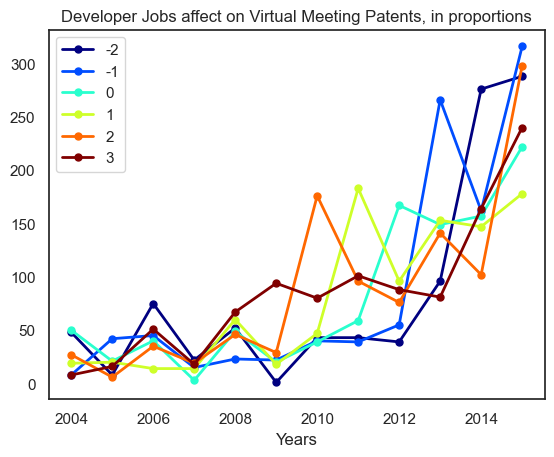

In [59]:
ax = dvlpr_ratio.plot(lw=2, colormap='jet', marker='.', markersize=10, title='Developer Jobs affect on Virtual Meeting Patents, in proportions')

<Axes: ylabel='Years'>

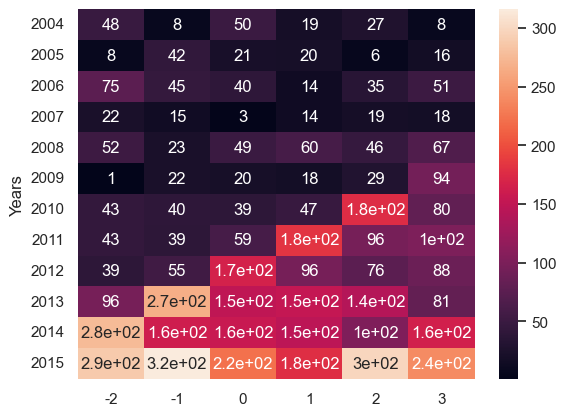

In [60]:
sns.heatmap(dvlpr_ratio, annot=True)